In [1]:
import numpy
import pandas

import json

from matplotlib import pyplot as plt

from helpers import network, plotting

In [2]:
with open("configs/microns_placement_7.json", "r") as fid:
    cfg = json.load(fid)

cfg["connectome"]["loading"]["conntility"] = "/home/reimann/Documents/data/microns/microns_mm3_connectome.h5"

plot_out = cfg["plotting"]["output_root"]
save_out = cfg["save"]["filename"]
save_id = cfg["save"]["id"]

cfg

{'connectome': {'cols_xyz': ['x_nm', 'y_nm', 'z_nm'],
  'loading': {'conntility': '/home/reimann/Documents/data/microns/microns_mm3_connectome.h5',
   'args': ['condensed']},
  'subnetwork': {'base_volume': [],
   'simplices': [{'column': 'cell_type',
     'function': 'isin',
     'args': [['23P', '4P', '6CT', '5P_IT', '5P_PT', '5P_NP', '6IT']]},
    {'column': 'x_nm', 'function': 'gt', 'args': [700000.0]},
    {'column': 'x_nm', 'function': 'lt', 'args': [1200000.0]},
    {'column': 'z_nm', 'function': 'gt', 'args': [700000.0]},
    {'column': 'z_nm', 'function': 'lt', 'args': [1000000.0]}],
   'neurons': {'name': 'Inhibitory',
    'filters': [{'column': 'cell_type',
      'function': 'isin',
      'args': [['BC', 'MC', 'NGC']]}]}}},
 'analysis': {'simplex_dimension': 6,
  'use_weight': 0,
  'min_degrees': {'In': 200, 'Out': 200},
  'normalize_mat': 0,
  'clustering': {'use': 'source',
   'cluster_param': 2.2,
   'merge_smaller_than': 0.05,
   'normalize_cluster_paths': 'pairs',
   'n

In [3]:
M = network.load_network(cfg["connectome"]["loading"])

Msmpl = network.filter_network(M, cfg["connectome"]["subnetwork"]["simplices"])
name_nrn = cfg["connectome"]["subnetwork"]["neurons"]["name"]
Mnrn = network.filter_network(M, cfg["connectome"]["subnetwork"]["neurons"]["filters"])

In [4]:
import tqdm 
import connalysis
import conntility

from scipy.stats import wasserstein_distance

msmpl = Msmpl.matrix.tocsc()
neigh_idx = conntility.analysis.neighborhood_indices(Msmpl.matrix)

mctrl = connalysis.randomization.configuration_model(Msmpl.matrix)
neigh_ctrl = conntility.analysis.neighborhood_indices(mctrl)

def degrees(m):
    return numpy.array(m.sum(axis=0)).flatten() + numpy.array(m.sum(axis=1)).flatten()

struc_compl = []

for i in tqdm.tqdm(numpy.arange(len(neigh_idx))):
    a = numpy.hstack([i, neigh_idx[i]])
    b = numpy.hstack([i, neigh_ctrl[i]])
    m1 = msmpl[numpy.ix_(a, a)]
    m2 = mctrl[numpy.ix_(b, b)]
    struc_compl.append(wasserstein_distance(degrees(m1), degrees(m2)))
struc_compl = numpy.array(struc_compl)

/home/reimann/venvs/bpsnap/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
100%|███████████████████████████████████████████████████████████████████████████| 14559/14559 [00:07<00:00, 1847.25it/s]


 2023-11-27 15:32:56,560: COMPUTE list of simplices by dimension


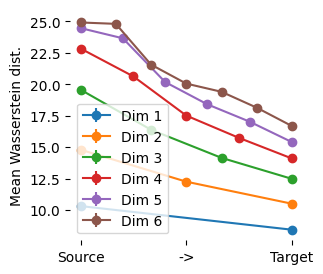

In [6]:
raw_smpls = connalysis.network.topology.list_simplices_by_dimension(Msmpl.matrix)
fig = plt.figure(figsize=(3, 3))
ax = fig.gca()

for i in range(1, len(raw_smpls) - 1):
    mn = struc_compl[raw_smpls[i]].mean(axis=0)
    sd = struc_compl[raw_smpls[i]].std(axis=0) / numpy.sqrt(raw_smpls[i].shape[0])
    
    ax.errorbar(numpy.linspace(0, 1, len(mn)), mn, yerr=sd, marker='o', label="Dim {0}".format(i))

plt.legend()
ax.set_ylabel("Mean Wasserstein dist.")
ax.set_xticks([0, 0.5, 1]); ax.set_xticklabels(["Source", "->", "Target"])
ax.set_frame_on(False)

fig.savefig("plots/microns/complexity_of_neighborhoods.pdf")